# Neural Networks retrieval on the Satellite Observations Dataset

In this final step we develop a model to estimate soil moisture using neural networks

Libraries we need are imported first

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import xarray as xr
from scipy.interpolate import griddata
from scipy import interpolate

import torch
from torch import nn, optim
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader

Data used in this exercise is stored in the DATA folder

In [4]:
thefile = '../../../DATA/TPdata_199301'
orig_data = pd.read_csv(thefile, sep='\t', header=None)
orig_data.columns = ["cellNr", "latitude", "longitude", "backscatter","emissivity_v","emissivity_h","ts_amplitude","ndvi","lmd_soilWetness"]
orig_data = orig_data.replace('   NaN',pd.NA)
data = orig_data
# test_data = orig_data
data['backscatter'] = pd.to_numeric(data['backscatter'])
data['emissivity_v'] = pd.to_numeric(data['emissivity_v'])
data['emissivity_h'] = pd.to_numeric(data['emissivity_h'])
data['ts_amplitude'] = pd.to_numeric(data['ts_amplitude'])
data['ndvi'] = pd.to_numeric(data['ndvi'])
data['lmd_soilWetness'] = pd.to_numeric(data['lmd_soilWetness'])
data = data.dropna()
# test_data = test_data.dropna()
# data = data.iloc[::5,:]
# test_data = test_data.iloc[1::5,:]
# data = data.iloc[0:len(test_data),:]

In [6]:
thres = len(data)
thres

44531

In [8]:
lati = data['latitude']
loni = data['longitude']

In [10]:
normalized_data=(data-data.min())/(data.max()-data.min())
data = normalized_data

In [12]:
back = data['backscatter'].values
lats = data['latitude'].values
lons = data['longitude'].values
emissivity_v = data['emissivity_v'].values
emissivity_h = data['emissivity_h'].values
ts_amplitude = data['ts_amplitude'].values
ndvi = data['ndvi'].values
lmd_soilWetness = data['lmd_soilWetness'].values

## Neural Network

In [15]:
hidden=100

In [17]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(5,hidden)  
        self.fc2 = nn.Linear(hidden,1)  

    def forward(self, x):
        x = torch.relu(self.fc1(x)) 
        x = self.fc2(x)               
        return x

In [19]:
alles = np.stack((back,emissivity_v,emissivity_h,ts_amplitude,ndvi),axis=1)

In [21]:
X_train = torch.tensor(alles).to(torch.float32)
y_train = torch.tensor(lmd_soilWetness).to(torch.float32)
y_train = y_train[...,None]

DataLoader

In [24]:
class MyDataset(Dataset):
    def __init__(self):
        self.data = X_train
        self.labels = y_train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

dataset = MyDataset()
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

# for batch in dataloader:
#     print("Batch Data:", batch[0])  
#     print("Batch Labels:", batch[1])

In [26]:
model = SimpleNN()  
criterion = nn.MSELoss()  
optimizer = optim.SGD(model.parameters(), lr=0.1)
iter=0

In [28]:
for epoch in range(100):  
  for inputs, labels in dataloader:
    model.train() 

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)  
    
    # Backward pass and optimize
    optimizer.zero_grad()  
    loss.backward()  
    optimizer.step()  

  if (epoch + 1) % 10 == 0:  
        print(f'Epoch [{epoch + 1}/100], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0290
Epoch [20/100], Loss: 0.0299
Epoch [30/100], Loss: 0.0246
Epoch [40/100], Loss: 0.0254
Epoch [50/100], Loss: 0.0302
Epoch [60/100], Loss: 0.0275
Epoch [70/100], Loss: 0.0122
Epoch [80/100], Loss: 0.0289
Epoch [90/100], Loss: 0.0264
Epoch [100/100], Loss: 0.0209


## Performance of the Neural Network

In [31]:
thefile_test = '../../../DATA/TPdata_199302'
test_data = pd.read_csv(thefile_test, sep='\t', header=None)
test_data.columns = ["cellNr", "latitude", "longitude", "backscatter","emissivity_v","emissivity_h","ts_amplitude","ndvi","lmd_soilWetness"]
test_data = test_data.replace('   NaN',pd.NA)
# data = test_data

In [33]:
test_lati = test_data['latitude']
test_loni = test_data['longitude']
test_data['backscatter'] = pd.to_numeric(test_data['backscatter'])
test_data['emissivity_v'] = pd.to_numeric(test_data['emissivity_v'])
test_data['emissivity_h'] = pd.to_numeric(test_data['emissivity_h'])
test_data['ts_amplitude'] = pd.to_numeric(test_data['ts_amplitude'])
test_data['ndvi'] = pd.to_numeric(test_data['ndvi'])
test_data['lmd_soilWetness'] = pd.to_numeric(test_data['lmd_soilWetness'])
test_data = test_data.dropna()
test_data

,cellNr,latitude,longitude,backscatter,emissivity_v,emissivity_h,ts_amplitude,ndvi,lmd_soilWetness
66285,66286.0,-53.125,-72.7083,-9.8801,0.8812,0.7832,26.8310,0.2267,0.7156
66287,66288.0,-53.125,-71.8750,-11.4260,0.8609,0.7506,26.2567,0.5848,0.6306
68030,68031.0,-52.625,-71.0526,-15.0699,0.9064,0.8230,22.9327,0.3404,0.4243
69791,69792.0,-52.125,-71.0633,-17.2656,0.9848,0.9565,26.5711,0.3311,0.4036
71571,71572.0,-51.625,-71.4765,-16.3460,0.9702,0.9332,29.2713,0.2347,0.3952
...,...,...,...,...,...,...,...,...,...
618712,618713.0,61.125,14.2446,-11.4483,0.9524,0.9056,6.1260,0.3580,0.7302
619408,619409.0,61.375,14.8696,-11.4410,0.9579,0.9186,6.4800,0.4447,0.8504
620568,620569.0,61.625,-97.6316,-11.6847,0.9813,0.8822,12.0637,-0.0047,0.5594
621461,621462.0,62.125,15.2452,-10.2578,0.9402,0.8961,5.2439,0.2240,0.8415


In [35]:
test_normalized_data=(test_data-test_data.min())/(test_data.max()-test_data.min())
test_data = test_normalized_data
test_data['latitude']=test_lati
test_data['longitude']=test_loni
test_data

,cellNr,latitude,longitude,backscatter,emissivity_v,emissivity_h,ts_amplitude,ndvi,lmd_soilWetness
66285,0.000000,-53.125,-72.7083,0.839947,0.478731,0.485413,0.402092,0.304231,0.639193
66287,0.000004,-53.125,-71.8750,0.766947,0.402985,0.412253,0.392817,0.722768,0.535862
68030,0.003129,-52.625,-71.0526,0.594875,0.572761,0.574731,0.339132,0.437120,0.285072
69791,0.006288,-52.125,-71.0633,0.491191,0.865299,0.874327,0.397894,0.426251,0.259908
71571,0.009480,-51.625,-71.4765,0.534616,0.810821,0.822038,0.441504,0.313581,0.249696
...,...,...,...,...,...,...,...,...,...
618712,0.990710,61.125,14.2446,0.765894,0.744403,0.760099,0.067694,0.457691,0.656941
619408,0.991958,61.375,14.8696,0.766238,0.764925,0.789273,0.073411,0.559023,0.803063
620568,0.994039,61.625,-97.6316,0.754730,0.852239,0.707585,0.163591,0.033777,0.449307
621461,0.995640,62.125,15.2452,0.822111,0.698881,0.738779,0.053447,0.301075,0.792244


In [37]:
test_back = test_data['backscatter'].values[0:thres]
test_lats = test_data['latitude'].values[0:thres]
test_lons = test_data['longitude'].values[0:thres]
test_emissivity_v = test_data['emissivity_v'].values[0:thres]
test_emissivity_h = test_data['emissivity_h'].values[0:thres]
test_ts_amplitude = test_data['ts_amplitude'].values[0:thres]
test_ndvi = test_data['ndvi'].values[0:thres]
test_lmd_soilWetness = test_data['lmd_soilWetness'].values[0:thres]

In [39]:
test_alles = np.stack((test_back,test_emissivity_v,test_emissivity_h,test_ts_amplitude,test_ndvi),axis=1)

In [41]:
model.eval()  
with torch.no_grad(): 
    testing_data = torch.tensor(test_alles).to(torch.float32)
    predictions = model(testing_data) 
    print(f'Predictions:\n{predictions}')

Predictions:
tensor([[0.1960],
        [0.1293],
        [0.1345],
        ...,
        [0.2323],
        [0.2583],
        [0.2623]])


In [43]:
len(predictions)

44531

In [45]:
output = predictions.detach().cpu().numpy()

In [47]:
output

array([[0.195993  ],
       [0.12925139],
       [0.13449787],
       ...,
       [0.23232405],
       [0.25829145],
       [0.26227576]], dtype=float32)

In [49]:
np.mean(output)

0.31737924

In [51]:
test_data = test_data.iloc[0:thres]
test_data['NN']=output

/var/folders/42/4grwdj956wxfq8phsmjtnjdm0000gn/T/ipykernel_40717/2176432666.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['NN']=output


In [53]:
test_data

,cellNr,latitude,longitude,backscatter,emissivity_v,emissivity_h,ts_amplitude,ndvi,lmd_soilWetness,NN
66285,0.000000,-53.125,-72.7083,0.839947,0.478731,0.485413,0.402092,0.304231,0.639193,0.195993
66287,0.000004,-53.125,-71.8750,0.766947,0.402985,0.412253,0.392817,0.722768,0.535862,0.129251
68030,0.003129,-52.625,-71.0526,0.594875,0.572761,0.574731,0.339132,0.437120,0.285072,0.134498
69791,0.006288,-52.125,-71.0633,0.491191,0.865299,0.874327,0.397894,0.426251,0.259908,0.048444
71571,0.009480,-51.625,-71.4765,0.534616,0.810821,0.822038,0.441504,0.313581,0.249696,0.070987
...,...,...,...,...,...,...,...,...,...,...
545737,0.859839,40.875,90.7438,0.891683,0.698134,0.620961,0.489622,0.088710,0.252249,0.210033
545746,0.859855,40.875,93.7190,0.739605,0.701119,0.638689,0.482593,0.111384,0.234743,0.233281
545748,0.859858,40.875,94.3802,0.759745,0.708209,0.652379,0.498551,0.090346,0.179796,0.232324
545750,0.859862,40.875,95.0413,0.719734,0.707836,0.655745,0.472197,0.083100,0.480306,0.258291


(-180.0, 180.0)

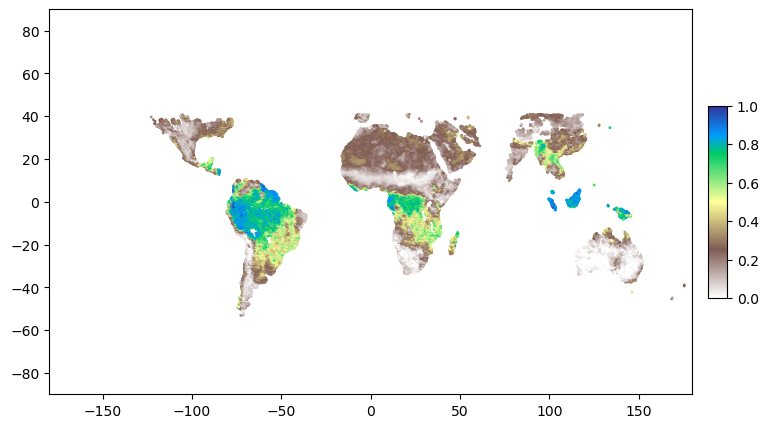

In [55]:
fig,ax = pl.subplots(figsize=(10, 5))
mesh = ax.scatter(test_data['longitude'],test_data['latitude'],c=test_data['NN'],s=1, cmap='terrain_r', vmin=0, vmax=1);
cbar = pl.colorbar(mesh, ax=ax, shrink=.5, pad=.02, aspect=10)
ax.set_ylim(-90,90)
ax.set_xlim(-180,180)
# ax.set_ylim(-20,0)
# ax.set_xlim(0,50)

(-180.0, 180.0)

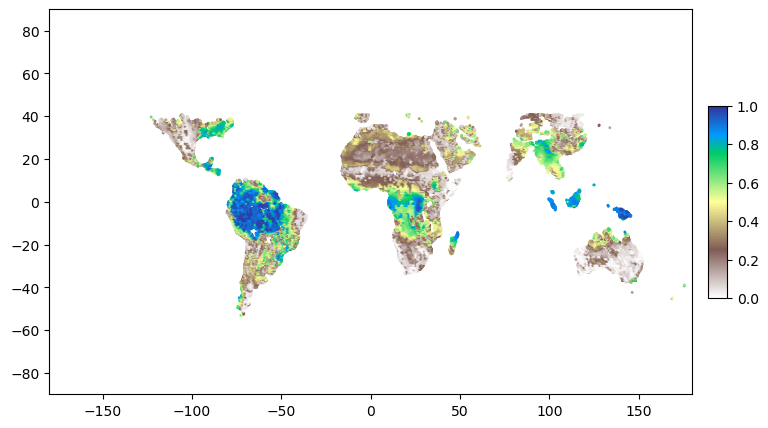

In [59]:
fig,ax = pl.subplots(figsize=(10, 5))
mesh = ax.scatter(test_data['longitude'],test_data['latitude'],c=test_data['lmd_soilWetness'],s=1, cmap='terrain_r', vmin=0, vmax=1);
cbar = pl.colorbar(mesh, ax=ax, shrink=.5, pad=.02, aspect=10)
ax.set_ylim(-90,90)
ax.set_xlim(-180,180)
# ax.set_ylim(-20,0)
# ax.set_xlim(0,50)